# New York Bike Share Big Query Data and 2017 Survey

Below are the packages that need to be installed to run this file completely. If there is a comment in the cell, it won't run.

* google-cloud-bigquery: Pip install big query for pulling publically available data via python
* pyarrow: Install a needed dependency for the .to_dataframe() function 
* geopy: Using for the NYBikeShare data. Needing to get the zipcodes from this database to match zipcodes with NYSurvey data for comparison.
* haversine: using to calculate the distance between two points on earth

In [ ]:
pip install google-cloud-bigquery

In [ ]:
pip install pyarrow

In [ ]:
pip install geopy

In [ ]:
pip install haversine

In [ ]:
pip install seaborn

In [ ]:
pip install arcgis

In [ ]:
pip install pandas

In [1]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [10]:
!jupyter nbextension enable arcgis --py --sys-prefix

Enabling notebook extension arcgis/extension...
      - Validating: OK


In [14]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# only import bigquery from google cloud
from google.cloud import bigquery
# import folium
import webbrowser
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
from haversine import haversine

plt.style.use('seaborn')

In [3]:
# Changing the settings to override this file path in the environment
import os

# Needing to have the key file downloaded to access via the api. The query can be used
# instead and utilized for this brief analysis.
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/tiareina/Downloads/compact-scene-317315-b4b3cd5c140c.json"

client = bigquery.Client() # Construct a BigQuery client object.

In [4]:
def bigQuery(q: str):
    query_job = client.query(q)  # Make an API request.
    return query_job.to_dataframe().copy() # collect results as a dataframe

def hs(row):
    loc1 = (row['start_station_latitude'],row['start_station_longitude'])
    loc2 = (row['end_station_latitude'], row['end_station_longitude'])
    return haversine(loc1,loc2,unit='mi')

### User Type Bike Trips

In [ ]:
riders = bigQuery(
    """
    SELECT usertype, count(*) as RideCount
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and 
    starttime < date('2018-01-01')
    GROUP BY usertype
    """
)

riders.usertype = riders.usertype.dropna()
riders.RideCount = riders.RideCount.astype(int)
riders = riders.sort_values(by='RideCount',ascending=False)[riders['usertype'] != ""]

riders.head()

In [ ]:
riders.plot(x='usertype', y='RideCount', kind='bar')

In [ ]:
#Calculates the average ride time in minutes instead of seconds
userAvgs = bigQuery(
    """
        SELECT usertype, AVG(tripduration)/60 as Average_Ride_Time
        FROM `bigquery-public-data.new_york_citibike.citibike_trips`
        GROUP BY usertype
    """
)

userAvgs = userAvgs[userAvgs['usertype']!='']
userAvgs.head()

In [6]:
# collect results as a dataframe
mostFreqRides = bigQuery(
    """
    SELECT usertype,
    start_station_latitude,
    start_station_longitude,
    end_station_latitude,
    end_station_longitude,
    count(*) AS Count_of_Trips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE stoptime > DATE('2017-01-01')
    GROUP BY usertype, start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude
    ORDER BY Count_of_Trips desc;
    """
)

,usertype,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,Count_of_Trips
0,Customer,40.765909,-73.976342,40.783070,-73.959390,6783
1,Customer,40.765909,-73.976342,40.765909,-73.976342,6662
2,Customer,40.764397,-73.973715,40.764397,-73.973715,5805
3,Subscriber,40.741740,-73.994156,40.745497,-74.001971,5666
4,Subscriber,40.751873,-73.977706,40.748549,-73.988084,5410


In [7]:
# Find the distance between the start station and the end station

mostFreqRides['distance'] = mostFreqRides.apply(lambda row: hs(row), axis=1)
mostFreqRides.head()

,usertype,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,Count_of_Trips,distance
0,Customer,40.765909,-73.976342,40.783070,-73.959390,6783,1.480728
1,Customer,40.765909,-73.976342,40.765909,-73.976342,6662,0.000000
2,Customer,40.764397,-73.973715,40.764397,-73.973715,5805,0.000000
3,Subscriber,40.741740,-73.994156,40.745497,-74.001971,5666,0.484564
4,Subscriber,40.751873,-73.977706,40.748549,-73.988084,5410,0.589785
...,...,...,...,...,...,...,...
508013,Subscriber,40.705381,-73.949765,40.739445,-73.976806,1,2.746724
508014,Subscriber,40.767801,-73.965921,40.717227,-73.988021,1,3.680827
508015,Subscriber,40.763154,-73.920827,40.781721,-73.945940,1,1.836426
508016,Subscriber,40.690649,-73.956431,40.716021,-73.999744,1,2.867061


In [ ]:
monthlyRides = bigQuery(
    """
    SELECT usertype,
    EXTRACT(month from starttime) as month,
    count(*) AS numOfTrips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and 
    starttime < date('2018-01-01')
    GROUP BY usertype, month
    ORDER BY usertype, month;
    """
)

monthlyRides.head()

In [ ]:
sns.lineplot(x='month',y='numOfTrips', hue='usertype',data=monthlyRides).set_title('Monthly rides in NY by User Type')

## arcGIS Maps

Instructions on how to create the environment and get the api for python via conda step by step provided by esri: https://developers.arcgis.com/python/guide/understanding-conda/ (at the bottom of doc.) For faster navigation, search: "Step by Step on macOS: A GIS Environment"

In [ ]:
stops = '''-3.203062,55.906437; -3.190080,55.935570'''



my_map = my_gis.map('Braidburn Valley', zoomlevel=13)
my_map

In [15]:
# mostFreqRides
from arcgis.gis import GIS
my_gis = GIS()
m = my_gis.map("New York City, NY")
m

MapView(layout=Layout(height='400px', width='100%'))

### Age Bike Trips

In [ ]:
AgeRiders = bigQuery(
    """
    SELECT birth_year,
    avg(tripduration)/60 AS AvgTripDuration,
    count(*) AS trips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and 
    starttime < date('2018-01-01')
    GROUP BY birth_year
    ORDER BY trips DESC;
    """
)

In [ ]:
AgeRiders=AgeRiders.dropna(axis=0).astype(int)
AgeRiders=AgeRiders[AgeRiders.birth_year >= 1946]
AgeRiders['age'] = 2021 - AgeRiders['birth_year']

In [ ]:
AgeRiders.head()

People in their 30s obviously have somewhere to go and want to stay active! Let's visualize this.

In [ ]:
AgeRiders.plot(x='age',y='trips',s='AvgTripDuration',kind='scatter')
plt.title('Total Trips in 2017 by Age in NY')

### Time Bike Trips

In [ ]:
bikeHour = bigQuery(
    """
    SELECT
    EXTRACT(hour from starttime) as starthour,
    count(*) AS numOfTrips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime > date('2017-01-01') and starttime < date('2018-01-01')
    GROUP BY starthour
    ORDER BY starthour
    """
)

In [ ]:
bikeHour.head()

In [ ]:
bikeHour.plot(x='starthour',y='numOfTrips',kind='bar').set_title('Number of Trips in 2017 by Hour')

## Survey Manipulation

In [22]:
NYSurvey = pd.read_csv('Citywide_Mobility_Survey_-_Main_Survey_2017.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
#list(NYSurvey.columns)

In [ ]:
#[i for i in NYSurvey.columns if 'BIKE' in i or "bike" in i]

In [23]:
relCols = [
 'UniqueID',
 'StartTime_EST',
 'FinishTime_EST',
 'qgender',
 'qzipcmb',
 'qbikeown',
#  'qbikemany',
#  'qBIKETYPE1',
#  'qBIKETYPE2',
#  'qBIKETYPE3',
#  'qBIKETYPE4',
#  'qBIKETYPE5',
#  'qBIKETYPE_other3',
#  'qBIKESTORE1',
#  'qBIKESTORE2',
#  'qBIKESTORE3',
#  'qBIKESTORE4',
#  'qBIKESTORE5',
#  'qBIKESTORE6',
#  'qBIKESTORE7',
#  'qBIKESTORE8',
#  'qBIKESTORE9',
#  'qBIKESTORE_other7',
 'qbikeride',
 'qbiketo',
 'qbikedays',
 'qcitibike',
 'qcitibikefreq',
 'qNOCITIBIKE1',
 'qNOCITIBIKE2',
 'qNOCITIBIKE3',
 'qNOCITIBIKE4',
 'qNOCITIBIKE5',
 'qNOCITIBIKE6',
 'qNOCITIBIKE7',
 'qNOCITIBIKE8',
 'qNOCITIBIKE9',
 'qNOCITIBIKE_other7'
]

In [28]:
nyBikeDF = NYSurvey[relCols]
citiBikeUsers = nyBikeDF[nyBikeDF['qcitibike'] == 1.0]
nonCitiBikeUsers = nyBikeDF[nyBikeDF['qcitibike'] != 1.0]

In [29]:
citiBikeUsers.groupby('qbikeown')['qcitibike'].coun t()
nonCitiBikeUsers.groupby('qbikeown')['qcitibike'].count()

qbikeown
1.0    1308
2.0    2028
3.0       7
Name: qcitibike, dtype: int64

In [7]:
surveyBikeAvgs = nyBikeDF.groupby('qzipcmb')[['qbikeown','qbikeride']].agg(np.average)
#surveyBikeAvgs = surveyBikeAvgs[surveyBikeAvgs['']]

<AxesSubplot:xlabel='qzipcmb', ylabel='qbikeown'>

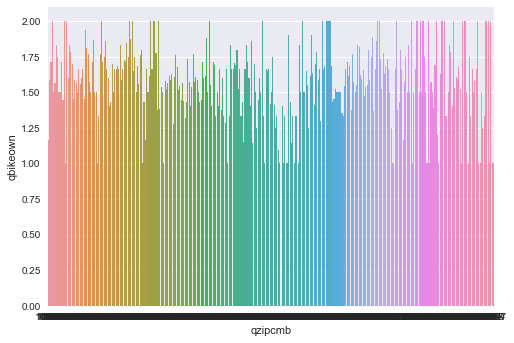

In [12]:
sns.barplot(y='qbikeown', x=surveyBikeAvgs.index, data=surveyBikeAvgs)

In [ ]:
def spaceReplacer(data):
    if data == " ":
        return np. NaN
    else:
        return data

In [ ]:
nyBikeDF['qcitibikefreq'] = nyBikeDF['qcitibikefreq'].apply(spaceReplacer).astype(float)

In [ ]:
nyBikeDF[nyBikeDF['qcitibike']==1.0]

## Connecting NY Lat, Long to the zips

In [ ]:
nytrips = bigQuery(
    """
    SELECT  *
    FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
    WHERE starttime > date('2017-01-01T00:00:00')
    LIMIT 10
    """
)

In [ ]:
nytrips[['start_station_latitude','start_station_longitude']]

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="NYBikeShare Mapping")

NYZipCodes = []

for i in nytrips[['start_station_latitude','start_station_longitude']].values:
    location = geolocator.reverse(i)
    NYZipCodes.append([i, location.address.split(',')[-2]])

In [ ]:
# Some entries won't have a zip code the way they are entered into the database. I don't know how we'd want to handle that if we want to use this method
# Which would be extract the long, lat from BQ, and 
pd.DataFrame(NYZipCodes,nytrips).reset_index().drop('index',axis=1)

## Comparison